# **This is the code for creating NARX Polynomial model for power consumption prediction**

**Note:** This code is involving with matrix operation

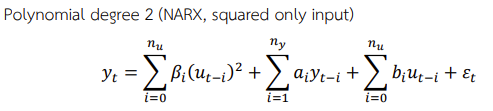

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score, max_error,median_absolute_error, mean_squared_log_error

In [ ]:
df_power = pd.read_csv('../input/residential-power-usage-3years-data-timeseries/power_usage_2016_to_2020.csv')
df_weather = pd.read_csv('../input/residential-power-usage-3years-data-timeseries/weather_2016_2020_daily.csv')

# Sum hourly power in each day
p1 = pd.Series(range(df_power.shape[0]), pd.period_range('2016-06-01 00:00:00', freq = '1H', periods = df_power.shape[0]))
df_power['StartDate'] = p1.to_frame().index.to_timestamp()
df_power['StartDate'] = pd.DatetimeIndex(df_power['StartDate']).date
df_power = df_power.groupby(['StartDate']).sum().reset_index().drop(["StartDate", "day_of_week"], axis=1)

In [ ]:
df_weather.head()

In [ ]:
df_power.head()

In [ ]:
# Feature Selection (use temperature average and wind speed average)
df_weather_filtered = df_weather.filter(["Temp_avg", "Wind_avg"])
df_weather_filtered

In [ ]:
# Train-Test Split
train_ratio = 0.75;
splitIdx = int(len(df_power)*train_ratio)

train_feature = df_weather_filtered.iloc[0:splitIdx+1,:];
train_label = df_power.iloc[0:splitIdx+1,:];
test_feature = df_weather_filtered.iloc[splitIdx+1:len(df_power),:];
test_label = df_power.iloc[splitIdx+1:len(df_power),:];

In [ ]:
train_feature

In [ ]:
# Least Square fitting on NARX model (Polynomial degree 2 on input only, i.e. y(t) = a1y(t-1) + a2y(t-2) + ... + b0u^2(t) + b1u^2(t-1) + ... + c0u(t) + c1u(t-1) + ... + bias)

# use current input (has u(t) term if 1, no u(t) term if 0)
curInput = 1;

# Memory n timestep for y (label) and u (input)
Ny = 6;
Nu = 3;

ytrue_train = train_label.iloc[Ny:len(train_label),:];
ytrue_test = test_label.iloc[Ny:len(test_label),:];

# Matrix Formulation for equation A*theta = ytrue_train, and we solve for theta
A = train_label.iloc[Ny-1:len(train_label)-1, :];
B = train_feature.iloc[Ny+curInput-1:len(train_label)+curInput-1, :];

for i in range(1,Ny):
    A = pd.concat([A.reset_index(drop=True), train_label.iloc[Ny-i-1:len(train_label)-i-1, :].reset_index(drop=True)], axis=1, ignore_index=True);
    
for i in range(1,Nu+curInput):
    B = pd.concat([B.reset_index(drop=True), train_feature.iloc[Ny+curInput-i-1:len(train_label)-i+curInput-1, :].reset_index(drop=True)], axis=1, ignore_index=True);
    
A = pd.concat([A.reset_index(drop=True), pow(B,2).reset_index(drop=True), B.reset_index(drop=True), pd.DataFrame(np.ones(len(train_label)-Ny)).reset_index(drop=True)], axis=1, ignore_index=True)

In [ ]:
# Matrix A contains [poly_1(previous output) poly_2(previous_current input) poly_1(previous_current input) bias]
A

In [ ]:
# Solve for equation => theta = A\ytrue_train
theta = np.linalg.lstsq(A.values,ytrue_train.values)

# Parameter for NARX polynomial mathematical modelling
theta[0]

In [ ]:
def performance_report(ytrue, ypred):
    print("R2 =", r2_score(ytrue, ypred))
    print("MSE =", mean_squared_error(ytrue, ypred))
    print("MAE =", mean_absolute_error(ytrue, ypred))
    print("MSLE =", mean_squared_log_error(ytrue, ypred))
    print("Exp. Var. =", explained_variance_score(ytrue, ypred))
    print("Max Error =", max_error(ytrue, ypred))

In [ ]:
# Evaluate Result on Train set
x_train = A
ypred_train = np.matmul(x_train, theta[0])

# Plot last 100 timesteps
plt.plot(ypred_train[len(ypred_train)-100:].values)
plt.plot(ytrue_train[len(ytrue_train)-100:].values)
performance_report(ytrue_train, ypred_train)

In [ ]:
# Evaluate Result on Train set

# Matrix Formulation for equation C*theta = ypred_test, and we solve for theta
C = test_label.iloc[Ny-1:len(test_label)-1, :];
D = test_feature.iloc[Ny+curInput-1:len(test_label)+curInput-1, :];

for i in range(1,Ny):
    C = pd.concat([C.reset_index(drop=True), test_label.iloc[Ny-i-1:len(test_label)-i-1, :].reset_index(drop=True)], axis=1, ignore_index=True);
    
for i in range(1,Nu+curInput):
    D = pd.concat([D.reset_index(drop=True), test_feature.iloc[Ny+curInput-i-1:len(test_label)-i+curInput-1, :].reset_index(drop=True)], axis=1, ignore_index=True);
    
C = pd.concat([C.reset_index(drop=True), pow(D,2).reset_index(drop=True), D.reset_index(drop=True), pd.DataFrame(np.ones(len(test_label)-Ny)).reset_index(drop=True)], axis=1, ignore_index=True)

x_test = C
ypred_test = np.matmul(x_test, theta[0])

# Plot last 100 timesteps
plt.plot(ypred_test[len(ypred_test)-100:].values)
plt.plot(ytrue_test[len(ytrue_test)-100:].values)
performance_report(ytrue_test, ypred_test)